In [6]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%matplotlib widget

# ruff: noqa: ERA001

Define the parameters and geometry for the simulation.

In [4]:
# room dimensions
import math

# R = 1.5
planeZ = 5  # height of the plane in space
height = 1  # height of the source
min_XY = 0.01  # plane dimensions in meters
max_XY = 100

check_patch_size = 0  # meant as check_plane_dimensions = not check_patch_size
resolution_of_sim = 40  # resolution of the range of simulated geometry
res = max(10, resolution_of_sim)  # min sim res is 10
patch_max_size_structure_inf_plane = 0.3  # cutoff for patch size for large pl
patch_max_size = 2
patch_min_size = 0.05
ir_length_s = 1  # min length otherwise out of bounds refl for first order
sampling_rate = 1000
max_order_k = 1
speed_of_sound = 346.18
absorption = 1  # param default 0.1

# create geometry
# for logspace logspace(-2, 6.64, res, base=2) # length for 0.25 to 100m
min_XY = math.log2(min_XY)
max_XY = math.log2(max_XY)

# circleRes = np.arange(0, 2 * np.pi * R, 0.1)  # circle of 1.5 meters
# probeDims = np.column_stack(
#    (np.cos(circleRes), np.sin(circleRes), [5] * len(circleRes)),
# )
debug__size_plane = np.logspace(min_XY, max_XY, res, base=2)
index_of_8m = (np.abs(debug__size_plane - 8)).argmin()  # 0.25m-100m res30 ~8m [17]

elements = [  # [17] corner 8.37m
    sp.geometry.Polygon(
        np.array(
            [
                [0, 0, planeZ],
                [0, i, planeZ],
                [i, i, planeZ],
                [i, 0, planeZ],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, 0, 1]),
    )
    for i in np.logspace(min_XY, max_XY, res, base=2)  # length for 0.25 to 100m
]

source_pos = [
    np.array([i / 2, i / 2, planeZ + height])
    for i in np.logspace(min_XY, max_XY, res, base=2)
]
sources = [
    sp.geometry.SoundSource(spos, np.array([0, 1, 0]), np.array([0, 0, 1]))
    for spos in source_pos
]
receiver_pos = source_pos  # sub to change

Calculate old slow approach for comparison.

In [11]:
debug__patch_sizeOrig = np.logspace(min_XY, max_XY, res, base=2)[index_of_8m] / 50
debug__patch_sizeNew1 = [min(i, 0.5) for i in (np.logspace(min_XY, max_XY, res, base=2)) / 50]
debug__patch_sizeNew1index = min(
    np.logspace(min_XY, max_XY, res, base=2)[index_of_8m] / 50,
    0.5,
)

start = datetime.now()
# init object
patch_values = np.arange(
    patch_max_size,
    patch_min_size,
    -(patch_max_size - patch_min_size) / res,
)

if check_patch_size:
    radiPlanes = [
        sp.DRadiosityFast.from_polygon(
            [elements[17]],
            i,
        )
        for i in patch_values
    ]
else:
    radiPlanes = [
        sp.DRadiosityFast.from_polygon(
            [element],  # singular element
            (float)(
                np.min(
                    [
                        (np.logspace(min_XY, max_XY, res, base=2)[index] ** 2 / 2000) ** 0.5,
                        patch_max_size_structure_inf_plane,
                    ],
                )
            ),
            # 0.3,
            # (float)(min(((np.logspace(min_XY, max_XY, res, base=2)[index]) / 50), 0.5))
        )
        for index, element in enumerate(elements)
    ]

# run simulation
source_ = pf.Coordinates(0, 0, 1)
receiver_ = pf.Coordinates(0, 0, 1)
frequencies = np.array([1000])
data_scattering = pf.FrequencyData(
    np.ones((source_.csize, receiver_.csize, frequencies.size)),
    frequencies,
)  # create directional scattering data (totally diffuse)

for indexForRadiPlanes, sim in enumerate(radiPlanes):
    # set directional scattering data
    sim.set_wall_scattering(np.arange(len(elements)), data_scattering, source_, receiver_)

    # set air absorption
    sim.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(data_scattering.frequencies), data_scattering.frequencies
        )
    )

    # set absorption coefficient
    sim.set_wall_absorption(
        np.arange(len(elements)),
        pf.FrequencyData(
            np.zeros_like(data_scattering.frequencies),
            data_scattering.frequencies,
        ),
    )

    # calculate from factors including directivity and absorption
    sim.bake_geometry(ff_method="universal", algorithm="order")

    if check_patch_size:
        # [i.run(sources[index_of_8m]) for i in radiPlanes]
        sim.init_source_energy(
            source_pos[index_of_8m],
        )
    else:
        # [i.run(sources[min(index, len(sources) - 1)]) for index, i in enumerate(radiPlanes)]
        sim.init_source_energy(
            source_pos[indexForRadiPlanes],
        )

    sim.calculate_energy_exchange(
        # receiver_pos[dependent on relevant index #1 or #radiPlanes], sim knows reci_pos
        speed_of_sound=speed_of_sound,
        histogram_time_resolution=1 / sampling_rate,
        histogram_length=ir_length_s,
        max_depth=max_order_k,
    )
    
    ir_fast = sim.collect_receiver_energy(
        receiver_pos=receiver_pos[__],  #for if?
        speed_of_sound=speed_of_sound,
        histogram_time_resolution=1 / sampling_rate,
    )

# gather energy at receiver  # receiver not as geometry

if check_patch_size:
    histograms = [
        i.energy_at_receiver(receivers[index_of_8m], ignore_direct=True) for i in radiPlanes
    ]
else:
    histograms = [
        i.energy_at_receiver(receivers[index], ignore_direct=True)
        for index, i in enumerate(radiPlanes)
    ]

# stop timer
delta = datetime.now() - start
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds * 1e6 + delta.microseconds) / 1e6

NameError: name 'index_of_8m' is not defined

Diffuse and specular Intensity with plotting

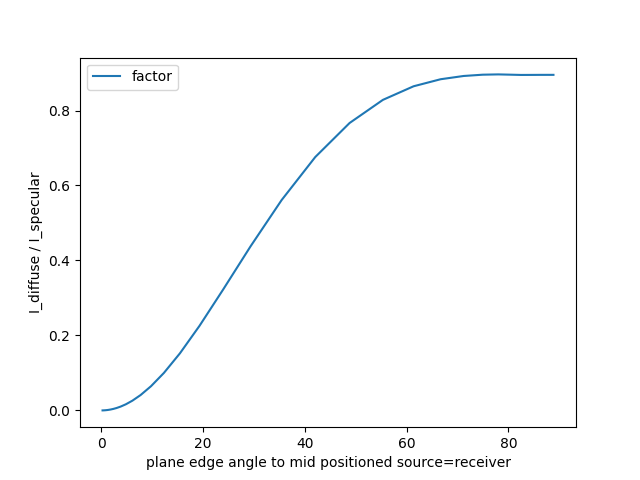

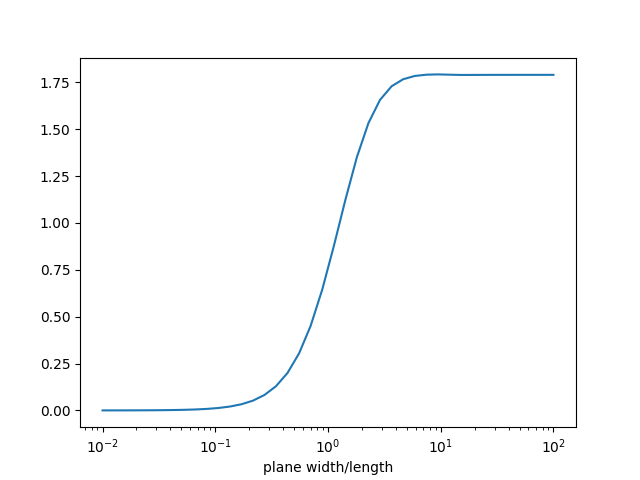

In [11]:
# Signal
I_diffuse_planes = [
    pf.Signal(i, sampling_rate=sampling_rate) for i in histograms
]

I_specular = 1 / (4 * np.pi * (height * 2) ** 2)
factors = [np.sum(i.time[:, :]) / I_specular for i in I_diffuse_planes]

# Plot the factors
plt.figure()
if check_patch_size:
    plt.plot(patch_values, factors, label="factor")
    plt.gca().invert_xaxis()
    plt.xlabel("patch size")
else:
    plt.plot(np.logspace(min_XY, max_XY, res, base=2), factors, label="factor")
    plt.xlabel("plane width/length")
    plt.xscale("log")

    plt.figure()
    plt.plot(
        np.arctan(np.logspace(min_XY, max_XY, res, base=2) / 2 / height)
        / np.pi
        * 180,
        [(i / 2) for i in factors],
        label="factor",
    )
    plt.xlabel("plane edge angle to mid positioned source=receiver")
    plt.xscale("linear")

plt.ylabel("I_diffuse / I_specular")
plt.legend()
plt.show()

Find signal points

In [1]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

